# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

HR-агентство хочет выяснить, какие факторы влияют на зарплату специалиста Data Scientist:

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?


На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Ответить на эти вопросы нам помогут данные о зарплатах в сфере Data Science с указанием характеристик.

Данные содержат следующие столбцы:
*   *work year* — год, в котором была выплачена зарплата;
*   *experience level* — опыт работы на должности в течение года со следующими возможными значениями: \
        - EN — Entry-level/Junior; \
        - MI — Mid-level/Intermediate; \
        - SE — Senior-level/Expert; \
        - EX — Executive-level/Director.
*   *employment type* — тип трудоустройства для этой роли: \
        - PT — неполный рабочий день; \
        - FT — полный рабочий день; \
        - CT — контракт; \
        - FL — фриланс.
*   *job title* — роль, в которой соискатель работал в течение года;
*   *salary* — общая выплаченная валовая сумма заработной платы;
*   *salary currency* — валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;
*   *salary in usd* — зарплата в долларах США;
*   *employee residence* — основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
*   *remote ratio* — общий объём работы, выполняемой удалённо: \
        - 0 — удалённой работы нет (менее 20 %); \
        - 50 — частично удалённая работа; \
        - 100 — полностью удалённая работа (более 80 %).
*   *company location* — страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166;
*   *company size* — среднее количество людей, работавших в компании в течение года: \
        - S — менее 50 сотрудников (небольшая компания); \
        - M — от 50 до 250 сотрудников (средняя компания); \
        - L — более 250 сотрудников (крупная компания).

Источник датасета: ["Data Science Job Salaries" (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

## Загрузка данных

In [215]:
#import the libraries
import pandas as pd, numpy as np

import scipy.stats as stats
import statsmodels.api as sm

from matplotlib import pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [216]:
#import the data set
salaries = pd.read_csv('data/ds_salaries.csv', usecols=lambda x: x != 'Unnamed: 0')
salaries.head(3)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M


In [217]:
#set significance level
alpha = 0.05 
print(f'Уровень значимости alpha = {alpha:.2f}')

Уровень значимости alpha = 0.05


## Описательный Анализ Данных

In [218]:
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 52.3+ KB


**Вывод:** \
В датасете 607 записей (без пропущенных значений).

## Преобразование Данных

Проверим данные на наличие дубликатов:

In [219]:
print(f'Количество дубликатов: {salaries[salaries.duplicated()].shape[0]}')

# Удаляем дубликаты:
salaries = salaries.drop_duplicates()
print(f'Размер таблицы после удаления дубликатов: {salaries.shape}')

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


Преобразование и удаление неинформативных признаков:

In [220]:
#find the top10 roles
top10 = salaries['job_title'].value_counts().nlargest(10)
print(top10)
print()

print(f'Количество позиций: {top10.sum()}')

job_title
Data Scientist                130
Data Engineer                 121
Data Analyst                   82
Machine Learning Engineer      39
Research Scientist             16
Data Science Manager           12
Data Architect                 11
Big Data Engineer               8
Machine Learning Scientist      8
Principal Data Scientist        7
Name: count, dtype: int64

Количество позиций: 434


In [221]:
#delete any record / row with job title not in the top10
salaries = salaries[~salaries['job_title'].isin(top10.index) == False]

In [222]:
#encoding (OrdinalEncoder) creates the same column name, thus enconding substituted for functions instead

#create a function to encode numerically the company size
def encode_the_size(data):
    #encode the company size by a relevant value
    if data['company_size'] == 'S':
        return 1
    elif data['company_size'] == 'M':
        return 2
    elif data['company_size'] == 'L':
        return 3
    #in case of errors
    else:
        return 0

#create a new column by applying the function
salaries['size'] = salaries.apply(encode_the_size, axis=1)


#create a function to encode numerically the experience level
def encode_the_exp_level(data):
    #encode the company size by a relevant value
    if data['experience_level'] == 'EN':
        return 1
    elif data['experience_level'] == 'MI':
        return 2
    elif data['experience_level'] == 'SE':
        return 3
    elif data ['experience_level'] == 'EX':
        return 4
    #in case of errors
    else:
        return 0

#create a new column by applying the function
salaries['exp_level'] = salaries.apply(encode_the_exp_level, axis=1)


#create a function to encode numerically the employment type 
def encode_the_employment_type(data):
    #encode the company size by a relevant value
    if data['employment_type'] == 'FL':
        return 1
    elif data['employment_type'] == 'CT':
        return 2
    elif data['employment_type'] == 'PT':
        return 3
    elif data ['employment_type'] == 'FT':
        return 4
    #in case of errors
    else:
        return 0

#create a new column by applying the function
salaries['emp_type'] = salaries.apply(encode_the_employment_type, axis=1)


#create a function to compare the employee and company location
def compare_location(data):
    #if same country
    if data['employee_residence'] == data['company_location']:
        return 1
    #if different country
    else:
        return 0

#create a new column by applying the function
salaries['location'] = salaries.apply(compare_location, axis=1)


In [223]:
#find the total number of positions with the same currency
total_count = salaries[salaries['salary'] == salaries['salary_in_usd']].count()
print(total_count.iloc[1])

#delete 2x salary features and leave salary_in_usd only - only viable feature needed for analysis
#delete all the categorical features that were converted into numerical features
salaries = salaries.drop(['salary', 'salary_currency', 'experience_level', 'employment_type', 'company_size',
                          'employee_residence', 'company_location'],
                         axis=1, errors='ignore')

#rename the columns
salaries = salaries.rename(columns={'salary_in_usd': 'salary',
                                    'size': 'company_size',
                                    'exp_level': 'experience_level',
                                    'emp_type': 'employment_type',
                                    
})

280


Проверка корректности типов признаков:

In [224]:
#convert dtype object to string
salaries['job_title'] = salaries['job_title'].astype('string')

Классификация признаков на числовые и категориальные:

In [225]:
numerical_only = salaries.select_dtypes(include='int64')
print('Numerical Features: \n', numerical_only.columns)
print()

categorical_only = salaries.select_dtypes(include='string')
print('Categorical Features: \n', categorical_only.columns)
print()

Numerical Features: 
 Index(['work_year', 'salary', 'remote_ratio', 'company_size',
       'experience_level', 'employment_type', 'location'],
      dtype='object')

Categorical Features: 
 Index(['job_title'], dtype='object')



Проверим данные на наличие выбросов:

In [226]:
#find any observations that are more than 1.5 IQR < Q1 OR 1.5 IQR > Q3 based on Tukey's Rule
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr_mod(salaries, 'salary')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 4
Результирующее число записей: 430


In [227]:
#delete the records by index
salaries = salaries.drop(outliers.index)

print('Вывод:')
print(f'Размер таблицы после преобразования данных: {salaries.shape}')

Вывод:
Размер таблицы после преобразования данных: (430, 8)


### Распределение Заработной Платы по Всем Позициям

In [228]:
#create side by side histogram and boxplot under feature 'Зарплата'
#set primary chart: histogram
fig = px.histogram(
    data_frame=salaries,
    x='salary',
    #set secondary chart: boxplot
    marginal='box',
    width=1100,
    height=600,
    color_discrete_sequence=['darkcyan'],
    title='Распределение Заработной Платы по Всем Позициям',
)

#set the title of the y-axis
fig.update_layout(
    xaxis_title='Заработная Плата',
    yaxis_title_text='Количество',
)

fig.show()

In [229]:
data_agg = salaries['salary'].describe().round(2).to_frame()
data_agg.columns = ['Размер Заработной Платы']
display(data_agg)
print(f"mode: {salaries['salary'].agg(lambda x: x.mode().tolist())}")

,Размер Заработной Платы
count,430.00
mean,105197.50
std,57371.77
min,2859.00
25%,62162.25
50%,99680.00
75%,144000.00
max,266400.00


mode: [100000, 120000, 150000]


**Вывод:** \
Судя по гистограмме и коробчатой диаграмме распределение заработной платы является слегка асимметричным, с перекосом влево. \
Распределение считается гауссовским, если среднее значение, медиана и мода идентичны: центральная тенденция распределение зарплат несильно отличается друг от друга, но все же необходим дополнительный статистический анализ.

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?


In [230]:
#filter by job title
ds_salary = salaries[salaries['job_title'] == 'Data Scientist']
ds_salary.head(3)

,work_year,job_title,salary,remote_ratio,company_size,experience_level,employment_type,location
0,2020,Data Scientist,79833,0,3,2,4,1
7,2020,Data Scientist,35735,50,3,2,4,1
10,2020,Data Scientist,51321,0,1,1,4,1


In [231]:
#create a boxplot
fig = px.box(
    data_frame=ds_salary,
    x='salary',
    y='work_year',
    color='work_year',
    #set horizontal orientation
    orientation='h',
    title='Распределение Заработной Платы для Data Scientists',
)
#set the title of the axis
fig.update_layout(
   xaxis_title_text='Заработная Плата',
   yaxis_title_text='Год',
   showlegend=False
)

fig.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [232]:
data_agg = ds_salary.groupby('work_year')['salary'].describe().round(2)
print('Распределение Заработной Платы для Data Scientists')
data_agg

Распределение Заработной Платы для Data Scientists


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,20.0,69669.05,33268.11,21669.0,41768.00,62726.0,94677.75,138350.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


**Вывод:** \
Коробчатая диаграмма показывает разницу в заработной плате год на год со значительным ростом в 2022 году. \
Однако, чтобы определить, являются ли эти различия статистически значимыми необходимо статистическое тестирование.

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

In [233]:
#filter by year and job title
salary_by_year = salaries[(salaries['work_year'] == 2022) & ((salaries['job_title'] == 'Data Scientist') | (salaries['job_title'] == 'Data Engineer'))]
salary_by_year.head(3)

,work_year,job_title,salary,remote_ratio,company_size,experience_level,employment_type,location
289,2022,Data Engineer,135000,100,2,3,4,1
292,2022,Data Scientist,130000,0,2,2,4,1
293,2022,Data Scientist,90000,0,2,2,4,1


In [234]:
#create a boxplot
fig = px.box(
    data_frame=salary_by_year,
    x='salary',
    y='job_title',
    color='job_title',
    #set horizontal orientation
    orientation='h',
    title='Распределение Заработной Платы в 2022 году',
)
#set the title of the axis
fig.update_layout(
   xaxis_title_text='Заработная Плата',
   yaxis_title_text='Специальность',
   showlegend=False
)
fig.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [235]:
data_agg = salary_by_year.groupby('job_title')['salary'].describe().round(2)
print('Распределение Заработной Платы в 2022 году')
data_agg

Распределение Заработной Платы в 2022 году


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,78.0,122096.04,53544.36,25000.0,78526.0,114000.0,160000.0,243900.0
Data Scientist,65.0,131366.94,55785.24,18442.0,95550.0,135000.0,170000.0,260000.0


**Вывод:** \
Распределения заработой платы для специальностей -  Data Scientist и Data Engineer слегка отличаются друг от друга, с распределением для Data Scientist, как немного более разнообразное по размаху и верхних квартилях. \
Однако, чтобы определить, являются ли эти различия статистически значимыми необходимо дополнительное статистическое тестирование.

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

In [236]:
#converted company_size to numerical feature for future statistical analysis, thus need to filter by company size for easier visualization
small = salaries[(salaries['job_title'] == 'Data Scientist') & (salaries['company_size'] == 1)]
medium = salaries[(salaries['job_title'] == 'Data Scientist') & (salaries['company_size'] == 2)]
large = salaries[(salaries['job_title'] == 'Data Scientist') & (salaries['company_size'] == 3)]

#create side-by-side plots
fig = make_subplots(rows=3, cols=1)

#first graph
fig.add_trace(
    go.Box(x=small['salary'], name='Небольшая Компания'),
    row=1, col=1
)

#set the same axis limits
fig.update_xaxes(range=[0, 300000])


#second graph
fig.add_trace(
    go.Box(x=medium['salary'], name='Средняя Компания'),
    row=2, col=1
)

#set the same axis limits
fig.update_xaxes(range=[0, 300000])


#third graph
fig.add_trace(
    go.Box(x=large['salary'], name='Крупная Компания'),
    row=3, col=1
)

#set the same axis limits
fig.update_xaxes(range=[0, 300000])

#set characteristics
fig.update_layout(height=800,
                  width=1100,
                  showlegend=False,
                  title_text='Распределение Заработной Платы для Data Scientists по Размеру Компании'
)

fig.show()

In [237]:
data_agg = ds_salary.groupby('company_size')['salary'].describe().round(2)
print('Распределение Заработной Платы для Data Scientists по Размеру Компании')
data_agg

Распределение Заработной Платы для Data Scientists по Размеру Компании


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
1,21.0,51925.76,33216.29,2859.0,21669.00,49268.0,82500.0,105000.0
2,66.0,120080.58,56347.79,4000.0,80000.00,119529.5,157500.0,260000.0
3,42.0,95380.17,55756.89,13400.0,42860.75,89694.0,133750.0,215300.0


**Вывод:** \
Распределения заработой платы по размеру компании отличаются друг от друга, с распределением для средних компаний, как более разнообразное по диапазону и верхних квартилях. \
Однако, чтобы определить, являются ли эти различия статистически значимыми необходимо статистическое тестирование.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

In [238]:
#filter by position
size_by_position = salaries[((salaries['job_title'] == 'Data Scientist') | (salaries['job_title'] == 'Data Engineer'))]
size_by_position.head(3)

,work_year,job_title,salary,remote_ratio,company_size,experience_level,employment_type,location
0,2020,Data Scientist,79833,0,3,2,4,1
7,2020,Data Scientist,35735,50,3,2,4,1
10,2020,Data Scientist,51321,0,1,1,4,1


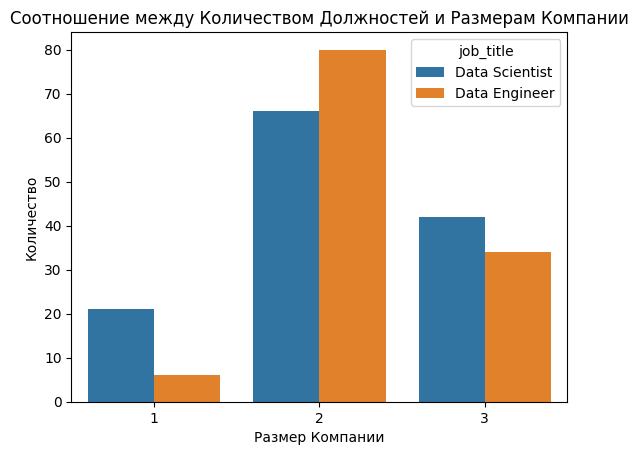

In [239]:
ax = sns.countplot(data=size_by_position, x=salaries['company_size'], hue='job_title')
ax.set(xlabel='Размер Компании', ylabel='Количество')
plt.title('Соотношение между Количеством Должностей и Размерам Компании')
plt.show()

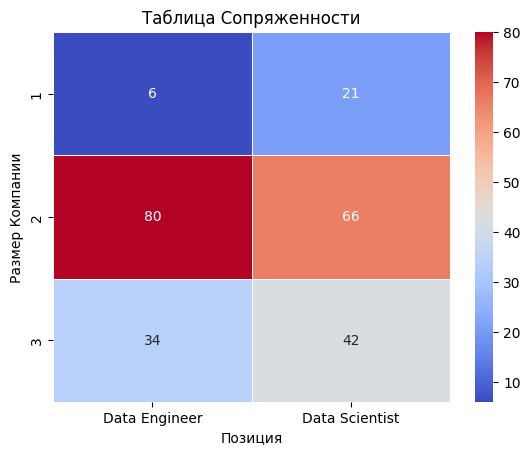

In [240]:
cross_tab = pd.crosstab(index=size_by_position['company_size'], columns=size_by_position['job_title'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Позиция', ylabel='Размер Компании')
plt.title('Таблица Сопряженности')
plt.show()

**Вывод:** \
Согласно графику подсчета и таблице сопряженности, существует связь между размером компании и количеством доступных позиций, при этом наименьшее количество позиций рекламируются в небольших компаний, а самый высокий рост в компаниях среднего размера для обеих специальностей. \
Однако, чтобы определить, являются ли эти различия статистически значимыми необходимо статистическое тестирование.

### Как соотносятся зарплаты специалистов Data Scientist при возможности удаленной работы?

In [241]:
#remote_ratio is a numerical feature, thus need to filter by remote_ratio for easier visualization
no_distance = salaries[(salaries['job_title'] == 'Data Scientist') & (salaries['remote_ratio'] == 0)]
part_distance = salaries[(salaries['job_title'] == 'Data Scientist') & (salaries['remote_ratio'] == 50)]
full_distance = salaries[(salaries['job_title'] == 'Data Scientist') & (salaries['remote_ratio'] == 100)]

#create side-by-side plots
fig = make_subplots(rows=3, cols=1)

#first graph
fig.add_trace(
    go.Box(x=no_distance['salary'], name='Очная Работа'),
    row=1, col=1
)

#set the same axis limits
fig.update_xaxes(range=[0, 300000])


#second graph
fig.add_trace(
    go.Box(x=part_distance['salary'], name='Гибридная Работа'),
    row=2, col=1
)

#set the same axis limits
fig.update_xaxes(range=[0, 300000])


#third graph
fig.add_trace(
    go.Box(x=full_distance['salary'], name='Удаленная Работа'),
    row=3, col=1
)

#set the same axis limits
fig.update_xaxes(range=[0, 300000])

#set characteristics
fig.update_layout(height=800,
                  width=1100,
                  showlegend=False,
                  title_text='Распределение Заработной Платы для Data Scientists по Возможности Удаленной Работы'
)

fig.show()

In [242]:
data_agg = ds_salary.groupby('remote_ratio')['salary'].describe().round(2)
print('Распределение Заработной Платы для Data Scientists по Возможности Удаленной Работы')
data_agg

Распределение Заработной Платы для Data Scientists по Возможности Удаленной Работы


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,38.0,98444.97,58647.60,2859.0,49781.25,93582.0,139050.0,215300.0
50,24.0,73827.83,36204.18,20171.0,47783.75,62726.0,102250.0,147000.0
100,67.0,112073.87,61329.08,5679.0,60412.00,105000.0,159100.0,260000.0


**Вывод:** \
Распределения заработой платы по возможности удаленной работы отличаются друг от друга, с наименьшим распределением для гибридной работы. \
Однако, чтобы определить, являются ли эти различия статистически значимыми необходимо статистическое тестирование.

### Влияет ли опыт работы на заработную плату Data Scientist?

In [243]:
#experience level converted to numerical feature for statistical testing, thus need to filter by experience_level for easier visualization
entry = salaries[(salaries['job_title'] == 'Data Scientist') & (salaries['experience_level'] == 1)]
middle = salaries[(salaries['job_title'] == 'Data Scientist') & (salaries['experience_level'] == 2)]
senior = salaries[(salaries['job_title'] == 'Data Scientist') & (salaries['experience_level'] == 3)]

#create side-by-side plots
fig = make_subplots(rows=3, cols=1)

#first graph
fig.add_trace(
    go.Box(x=entry['salary'], name='Junior'),
    row=1, col=1
)

#set the same axis limits
fig.update_xaxes(range=[0, 300000])


#second graph
fig.add_trace(
    go.Box(x=middle['salary'], name='Intermediate'),
    row=2, col=1
)

#set the same axis limits
fig.update_xaxes(range=[0, 300000])


#third graph
fig.add_trace(
    go.Box(x=senior['salary'], name='Expert'),
    row=3, col=1
)

#set the same axis limits
fig.update_xaxes(range=[0, 300000])

#set characteristics
fig.update_layout(height=800,
                  width=1100,
                  showlegend=False,
                  title_text='Распределение Заработной Платы для Data Scientists по Опыту Работы'
)

fig.show()

In [244]:
data_agg = ds_salary.groupby('experience_level')['salary'].describe().round(2)
print('Распределение Заработной Платы для Data Scientists по Опыту Работы')
data_agg

Распределение Заработной Платы для Data Scientists по Опыту Работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
1,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
2,59.0,81891.76,47257.88,2859.0,41339.0,76958.0,118529.50,200000.0
3,48.0,145267.33,50597.67,20171.0,104843.0,142200.0,180000.00,260000.0


**Вывод:** \
Как и стоило ожидать заработная плата растет в зависимости от опыта работы. \
Однако, чтобы определить, являются ли эти различия статистически значимыми необходимо статистическое тестирование.

## Статистический анализ данных

In [245]:
#function for p-value for normality testing
def decision_normality(p):
    print(f'p-value = {p:.3f}')
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha:.2f}. Распределение отлично от нормального')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha:.2f}. Распределение является нормальным')


#function for Anderson Darling normality testing
def anderson_darling(x):
    for i in range(len(x.critical_values)):
        sig_lev, crit_val = x.significance_level[i], x.critical_values[i]
        if x.statistic < crit_val:
            print(f'нормальное распределение: {crit_val} критическое значение на {sig_lev}% уровня значимости')
        else:
            print(f'ассиметричное распределение: {crit_val} критическое значение на {sig_lev}% уровня значимости')


#function for p-value comparison for hypothesis testing
def decision_hypothesis(p):
    print(f'p-value = {p:.3f}')
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.')

### **1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?**

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер заработной платы не отличается год на год: 2020 ($μ_1$), 2021 ($μ_2$), 2022 ($u_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): размер заработной платы отличается год на год: 2020 ($μ_1$), 2021 ($μ_2$), 2022 ($u_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

#### Проверка на Нормальность

С помощью теста Shapiro-Wilk проверим, распределён ли признак нормально:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [246]:
#obtain the sample by year
ds_salary_2020 = ds_salary.loc[ds_salary['work_year'] == 2020, 'salary']
ds_salary_2021 = ds_salary.loc[ds_salary['work_year'] == 2021, 'salary']
ds_salary_2022 = ds_salary.loc[ds_salary['work_year'] == 2022, 'salary']

#execute Shapiro-Wilk
print('Для 2020:')
result = stats.shapiro(ds_salary_2020)
decision_normality(result[1])
print()

print('Для 2021:')
result = stats.shapiro(ds_salary_2021)
decision_normality(result[1])
print()

print('Для 2022:')
result = stats.shapiro(ds_salary_2022)
decision_normality(result[1])

Для 2020:
p-value = 0.145
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для 2021:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для 2022:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


С помощью теста Anderson-Darling проверим, распределён ли признак нормально:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [247]:
#execute Anderson-Darling
print('Для 2020:')
result = stats.anderson(ds_salary_2020)
print('stat=%.3f' % (result.statistic))

#interpret the result
anderson_darling(result)
print()

print('Для 2021:')
result = stats.anderson(ds_salary_2021)
print('stat=%.3f' % (result.statistic))

#interpret the result
anderson_darling(result)
print()

print('Для 2022:')
result = stats.anderson(ds_salary_2022)
print('stat=%.3f' % (result.statistic))

#interpret the result
anderson_darling(result)

Для 2020:
stat=0.583
ассиметричное распределение: 0.506 критическое значение на 15.0% уровня значимости
ассиметричное распределение: 0.577 критическое значение на 10.0% уровня значимости
нормальное распределение: 0.692 критическое значение на 5.0% уровня значимости
нормальное распределение: 0.807 критическое значение на 2.5% уровня значимости
нормальное распределение: 0.96 критическое значение на 1.0% уровня значимости

Для 2021:
stat=0.449
нормальное распределение: 0.534 критическое значение на 15.0% уровня значимости
нормальное распределение: 0.609 критическое значение на 10.0% уровня значимости
нормальное распределение: 0.73 критическое значение на 5.0% уровня значимости
нормальное распределение: 0.852 критическое значение на 2.5% уровня значимости
нормальное распределение: 1.013 критическое значение на 1.0% уровня значимости

Для 2022:
stat=0.214
нормальное распределение: 0.546 критическое значение на 15.0% уровня значимости
нормальное распределение: 0.621 критическое значение на 1

Проверка на равенство дисперсий между выборками данных:

In [248]:
#execute Levene Test for variance equality
result = stats.levene(ds_salary_2020, ds_salary_2021, ds_salary_2022)
pv = result[1]
print(f'p-value = {pv:.3f}')

#interpret the result
if pv <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

p-value = 0.040
неравная дисперсия, необходимо использовать непараметрические тесты



In [249]:
#Bartlett's Test
test_statistic, p_value = stats.bartlett(ds_salary_2020, ds_salary_2021, ds_salary_2022)

print(f'{test_statistic:.7f}, {p_value:.7f}')

#interpret the result
if p_value <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

7.0473345, 0.0294911
неравная дисперсия, необходимо использовать непараметрические тесты



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - Год: количественный;
* Количество анализируемых групп: 3;
* Зависимость групп: независимы;
* Распределение по нормальному закону: да, но при неравных дисперсий используются только непараметрические тесты.

Чтобы проверить нашу гипотезу, можно использовать **Kruskal-Wallis** для сравнения распределений на основе рангов.

In [250]:
#Kruskal-Wallis Test
_, p = stats.kruskal(ds_salary_2020, ds_salary_2021, ds_salary_2022)

#interpret the result
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Для дополнительной проверки можно исключить год 2020 из анализа, и сравнить данные по двум последним годам, используя другой тест.

*Нулевая гипотеза* ($H_0$): размер заработной платы за 2021 год ($μ_1$) больше или равен размеру заработной платы за 2022 год ($u_2$).

$$ H_0 : μ_1 => μ_2$$

*Альтернативная гипотеза* ($H_1$): размер заработной платы за 2021 год ($μ_1$) меньше размеру заработной платы за 2022 год ($u_2$).

$$ H_1 : μ_1 < μ_2 $$

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - Год: количественный;
* Количество анализируемых групп: 2;
* Зависимость групп: независимы;
* Распределение по нормальному закону: да.

Чтобы проверить нашу гипотезу, можно использовать **Двухвыборочный t-Критерий** для сравнения распределений.

In [251]:
#execute Levene Test for variance equality
result = stats.levene(ds_salary_2021, ds_salary_2022)
pv = result[1]
print(f'p-value = {pv:.3f}')

#interpret the result
if pv <= alpha:
    print('неравная дисперсия, поэтому equal_var=False в stats.ttest_ind.')
else:
    print('равная дисперсия, поэтому equal_var=True в stats.ttest_ind.')
print()

#two-sample test
if pv <= alpha:
    _, p = stats.ttest_ind(ds_salary_2021, ds_salary_2022,
                           alternative='less',
                           equal_var=False)
else:
    _, p = stats.ttest_ind(ds_salary_2021, ds_salary_2022,
                           alternative='less',
                           equal_var=True)

#interpret the result
decision_hypothesis(p)

p-value = 0.264
равная дисперсия, поэтому equal_var=True в stats.ttest_ind.

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** \
Проведены два теста -  непараметрический и параметрический, и в обоих случаях с риском в 5%, результат в пользу принятия альтернативной гипотезы, то есть заработная плата отличается год на год. \
Размер заработной платы за 2022 год значительно больше заработной платы за предыдущее годы. \
Есть основания утверждать, что размер заработной платы увеличивается год на год для специальности Data Scientist.

### **2. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?**


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер заработной платы Data Scientist ($μ_1$) меньше или равно размеру заработной платы Data Engineer ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер заработной платы Data Scientist ($μ_1$) больше размеру заработной платы Data Engineer ($μ_2$).
$$ H_1 : μ_1 > μ_2$$

#### Проверка на Нормальность

С помощью теста Shapiro-Wilk проверим, распределён ли признак нормально.

In [252]:
#obtain the sample by position
salary4ds = salary_by_year.loc[salary_by_year['job_title'] == 'Data Scientist', 'salary']
salary4en = salary_by_year.loc[salary_by_year['job_title'] == 'Data Engineer', 'salary']

#execute Shapiro-Wilk
print('Для Data Scientist:')
result = stats.shapiro(salary4ds)
decision_normality(result[1])
print()

print('Для Data Engineer:')
result = stats.shapiro(salary4en)
decision_normality(result[1])
print()

Для Data Scientist:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Data Engineer:
p-value = 0.021
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального



С помощью теста Anderson-Darling проверим, распределён ли признак нормально.

In [253]:
#execute Anderson-Darling
print('Для Data Scientist:')
result = stats.anderson(salary4ds)
print('stat=%.3f' % (result.statistic))

#interpret the result
anderson_darling(result)
print()

print('Для Data Engineer:')
result = stats.anderson(salary4en)
print('stat=%.3f' % (result.statistic))

#interpret the result
anderson_darling(result)

Для Data Scientist:
stat=0.214
нормальное распределение: 0.546 критическое значение на 15.0% уровня значимости
нормальное распределение: 0.621 критическое значение на 10.0% уровня значимости
нормальное распределение: 0.746 критическое значение на 5.0% уровня значимости
нормальное распределение: 0.87 критическое значение на 2.5% уровня значимости
нормальное распределение: 1.034 критическое значение на 1.0% уровня значимости

Для Data Engineer:
stat=0.841
ассиметричное распределение: 0.55 критическое значение на 15.0% уровня значимости
ассиметричное распределение: 0.626 критическое значение на 10.0% уровня значимости
ассиметричное распределение: 0.752 критическое значение на 5.0% уровня значимости
нормальное распределение: 0.877 критическое значение на 2.5% уровня значимости
нормальное распределение: 1.043 критическое значение на 1.0% уровня значимости


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - Размер Заработной Платы: количественный;
* Количество анализируемых групп: 2;
* Зависимость групп: независимы;
* Распределение по нормальному закону: нет.
  - одна группа (Data Engineer) не соответствует закону, поэтому необходимо воспользоваться непараметрическим тестом.

Чтобы проверить нашу гипотезу, можно использовать **Mann Whitney U-Test** для сравнения распределений на основе рангов.

In [254]:
#Mann Whitney U-Test
_, p = stats.mannwhitneyu(salary4ds, salary4en, alternative='greater')

#interpret the result
decision_hypothesis(p)

p-value = 0.128
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:** \
По графику размер заработной платы для Data Scientist немного выше, чем размер заработной платы для Data Engineer, однако по статистическому тесту, включая риск в 5% это разница не статистически значима. \
Разница незначительна, поэтому нет оснований утверждать, что разница в зарплате между Data Scientist и Data Engineer значительно отличима, оплата труда примерно одинакова.

### 3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы не отличается в зависимости от размера компании: небольшая компания ($μ_1$), средняя компания ($μ_2$), крупная компания ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: размер заработной платы отличается в зависимости от размера компании: небольшая компания ($μ_1$), средняя компания ($μ_2$), крупная компания ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

#### Проверка на нормальность

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [255]:
#obtain the sample by company size
small_sized = ds_salary.loc[ds_salary['company_size'] == 1, 'salary']
medium_sized = ds_salary.loc[ds_salary['company_size'] == 2, 'salary']
large_sized = ds_salary.loc[ds_salary['company_size'] == 3, 'salary']

#execute Shapiro-Wilk
print('Для Небольной Компании:')
result = stats.shapiro(small_sized)
decision_normality(result[1])
print()

print('Для Средней Компании:')
result = stats.shapiro(medium_sized)
decision_normality(result[1])
print()

print('Для Крупной Компании:')
result = stats.shapiro(large_sized)
decision_normality(result[1])

Для Небольной Компании:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Средней Компании:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Крупной Компании:
p-value = 0.030
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


С помощью теста Anderson-Darling проверим, распределён ли признак нормально.

In [256]:
#execute Anderson-Darling
print('Для Небольной Компании:')
result = stats.anderson(small_sized)
print('stat=%.3f' % (result.statistic))

#interpret the result
anderson_darling(result)
print()

print('Для Средней Компании:')
result = stats.anderson(medium_sized)
print('stat=%.3f' % (result.statistic))

#interpret the result
anderson_darling(result)
print()

print('Для Крупной Компании:')
result = stats.anderson(large_sized)
print('stat=%.3f' % (result.statistic))

#interpret the result
anderson_darling(result)

Для Небольной Компании:
stat=0.417
нормальное распределение: 0.508 критическое значение на 15.0% уровня значимости
нормальное распределение: 0.579 критическое значение на 10.0% уровня значимости
нормальное распределение: 0.694 критическое значение на 5.0% уровня значимости
нормальное распределение: 0.81 критическое значение на 2.5% уровня значимости
нормальное распределение: 0.963 критическое значение на 1.0% уровня значимости

Для Средней Компании:
stat=0.165
нормальное распределение: 0.546 критическое значение на 15.0% уровня значимости
нормальное распределение: 0.622 критическое значение на 10.0% уровня значимости
нормальное распределение: 0.746 критическое значение на 5.0% уровня значимости
нормальное распределение: 0.87 критическое значение на 2.5% уровня значимости
нормальное распределение: 1.035 критическое значение на 1.0% уровня значимости

Для Крупной Компании:
stat=0.738
ассиметричное распределение: 0.533 критическое значение на 15.0% уровня значимости
ассиметричное распреде

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - Размер Компании / Размер Заработной Платы: количественный;
* Количество анализируемых групп: 3;
* Зависимость групп: независимы;
* Распределение по нормальному закону: нет.
  - 2х группы (small, medium) распределены нормально, но одна группа (large) нет, поэтому необходимо воспользоваться непараметрическим тестом.

Чтобы проверить нашу гипотезу, можно использовать **Kruskal-Wallis** для сравнения распределений на основе рангов.

In [257]:
#execute Kruskal-Wallis
_, p = stats.kruskal(small_sized, medium_sized, large_sized)

#interpret the result
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** \
При риске в 5% результат в пользу принятия альтернативной гипотезы, то есть заработная плата отличается в зависимости от размера компании. По графику видно, что уровень заработной платы выше, если сотрудник работает в средней или крупной компании по сравнению с маленькими организациями. \
Есть основания утверждать, что размер заработной платы выше в средних и крупных компаниях для специальности Data Scientist.

### 4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между тем, в какой компании сотрудник работает, и его специальностью нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между тем, в какой компании сотрудник работает, и его специальностью есть взаимосвязь (признаки зависимы).


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - Специальность: категориальный;
* Количество анализируемых групп: 2;
* Зависимость групп: независимы.

Чтобы проверить нашу гипотезу, можно использовать **${\chi}^2$** (хи-квадрат).

In [258]:
#create a contingency table
cross_table = pd.crosstab(size_by_position['company_size'], size_by_position['job_title'])
cross_table

job_title,Data Engineer,Data Scientist
company_size,,
1,6,21
2,80,66
3,34,42


**${\chi}^2$** основан на аппроксимации, Fisher's Exact Test является одним из точных тестов. \
Когда более 20% ячеек имеют ожидаемые частоты <5, нам необходимо использовать Fisher's Exact Test, поскольку применение метода аппроксимации неадекватно.

In [259]:
#check whether any number of occurencies are less than 5
check_table = []
for x in cross_table['Data Engineer']:
    for y in cross_table['Data Scientist']:
        if x < 5:
            check_table.append(x)
        if y < 5:
            check_table.append(y)

if len(check_table) > 0:
    print("использовать Fisher's Exact Test")
else:
    print("использовать Chi-Squared Test")

использовать Chi-Squared Test


In [260]:
#Chi-Squared Test
_, p, _, _ = stats.chi2_contingency(cross_table)

#interpret the result
decision_hypothesis(p)

p-value = 0.006
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** \
Согласно графику подсчета и таблице сопряженности существует связь между размером компании и количеством доступных должностей. По результатам тестирования критерии хи-квадрата взаимосвязь статистически значимая.

### 5. Как соотносятся зарплаты специалистов Data Scientist при возможности удаленной работы?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы не отличается в зависимости от возможности удаленной работы: очная работа ($μ_1$), гибридная работа ($μ_2$), удаленная работа ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: размер заработной платы отличается в зависимости от возможности удаленной работы: очная работа ($μ_1$), гибридная работа ($μ_2$), удаленная работа ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

#### Проверка на нормальность

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [261]:
#obtain the sample by distance work
no_dist_work = ds_salary.loc[ds_salary['remote_ratio'] == 0, 'salary']
part_dist_work = ds_salary.loc[ds_salary['remote_ratio'] == 50, 'salary']
full_dist_work = ds_salary.loc[ds_salary['remote_ratio'] == 100, 'salary']

#execute Shapiro-Wilk
print('Для Очной Работы:')
result = stats.shapiro(no_dist_work)
decision_normality(result[1])
print()

print('Для Гибридной Работы:')
result = stats.shapiro(part_dist_work)
decision_normality(result[1])
print()

print('Для Удаленной Работы:')
result = stats.shapiro(full_dist_work)
decision_normality(result[1])

Для Очной Работы:
p-value = 0.331
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Гибридной Работы:
p-value = 0.387
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Удаленной Работы:
p-value = 0.199
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


С помощью теста Anderson-Darling проверим, распределён ли признак нормально.

In [262]:
#execute Anderson-Darling
print('Для Очной Работы:')
result = stats.anderson(no_dist_work)
print('stat=%.3f' % (result.statistic))

#interpret the result
anderson_darling(result)
print()

print('Для Гибридной Работы:')
result = stats.anderson(part_dist_work)
print('stat=%.3f' % (result.statistic))

#interpret the result
anderson_darling(result)
print()

print('Для Удаленной Работы:')
result = stats.anderson(full_dist_work)
print('stat=%.3f' % (result.statistic))

#interpret the result
anderson_darling(result)

Для Очной Работы:
stat=0.283
нормальное распределение: 0.529 критическое значение на 15.0% уровня значимости
нормальное распределение: 0.603 критическое значение на 10.0% уровня значимости
нормальное распределение: 0.723 критическое значение на 5.0% уровня значимости
нормальное распределение: 0.844 критическое значение на 2.5% уровня значимости
нормальное распределение: 1.004 критическое значение на 1.0% уровня значимости

Для Гибридной Работы:
stat=0.362
нормальное распределение: 0.513 критическое значение на 15.0% уровня значимости
нормальное распределение: 0.584 критическое значение на 10.0% уровня значимости
нормальное распределение: 0.701 критическое значение на 5.0% уровня значимости
нормальное распределение: 0.817 критическое значение на 2.5% уровня значимости
нормальное распределение: 0.972 критическое значение на 1.0% уровня значимости

Для Удаленной Работы:
stat=0.425
нормальное распределение: 0.546 критическое значение на 15.0% уровня значимости
нормальное распределение: 0.6

Проверка на равенство дисперсий между выборками данных:

In [263]:
#execute Levene Test for variance equality
result = stats.levene(no_dist_work, part_dist_work, full_dist_work)
pv = result[1]
print(f'p-value = {pv:.3f}')

#interpret the result
if pv <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')

p-value = 0.026
неравная дисперсия, необходимо использовать непараметрические тесты


In [264]:
#Bartlett's Test
test_statistic, p_value = stats.bartlett(no_dist_work, part_dist_work, full_dist_work)

print(f'{test_statistic:.7f}, {p_value:.7f}')

#interpret the result
if p_value <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

7.8546344, 0.0196964
неравная дисперсия, необходимо использовать непараметрические тесты



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - Общий Объем Работы: количественный;
* Количество анализируемых групп: 3;
* Зависимость групп: независимы;
* Распределение по нормальному закону: да, но при неравных дисперсий используются только непараметрические тесты.

Чтобы проверить нашу гипотезу, воспользуемся **Kruskal-Wallis** для сравнения распределений.

In [265]:
#execute Kruskal-Wallis
_, p = stats.kruskal(no_dist_work, part_dist_work, full_dist_work)

#interpret the result
decision_hypothesis(p)

p-value = 0.026
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** \
Распределения заработой платы по возможности удаленной работы отличаются друг от друга, с наименьшим распределением для гибридной работы, и по результатам теста являются статистически значимыми.

### 6a. Влияет ли опыт работы на заработную плату Data Scientist??

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы не отличается по опыту работы: junior ($μ_1$), intermediate ($μ_2$), expert ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: размер заработной платы отличается по опыту работы: junior ($μ_1$), intermediate ($μ_2$), expert ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

#### Проверка на нормальность

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [266]:
#obtain the sample by experience level
junior = ds_salary.loc[ds_salary['experience_level'] == 1, 'salary']
intermediate = ds_salary.loc[ds_salary['experience_level'] == 2, 'salary']
expert = ds_salary.loc[ds_salary['experience_level'] == 3, 'salary']

#execute Shapiro-Wilk
print('Для Junior:')
result = stats.shapiro(junior)
decision_normality(result[1])
print()

print('Для Intermediate:')
result = stats.shapiro(intermediate)
decision_normality(result[1])
print()

print('Для Expert:')
result = stats.shapiro(expert)
decision_normality(result[1])

Для Junior:
p-value = 0.174
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Intermediate:
p-value = 0.146
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для Expert:
p-value = 0.981
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


С помощью теста Anderson-Darling проверим, распределён ли признак нормально.

In [267]:
#execute Anderson-Darling
print('Для Junior:')
result = stats.anderson(junior)
print('stat=%.3f' % (result.statistic))

#interpret the result
anderson_darling(result)
print()

print('Для Intermediate:')
result = stats.anderson(intermediate)
print('stat=%.3f' % (result.statistic))

#interpret the result
anderson_darling(result)
print()

print('Для Expert:')
result = stats.anderson(expert)
print('stat=%.3f' % (result.statistic))

#interpret the result
anderson_darling(result)

Для Junior:
stat=0.484
нормальное распределение: 0.51 критическое значение на 15.0% уровня значимости
нормальное распределение: 0.58 критическое значение на 10.0% уровня значимости
нормальное распределение: 0.696 критическое значение на 5.0% уровня значимости
нормальное распределение: 0.812 критическое значение на 2.5% уровня значимости
нормальное распределение: 0.966 критическое значение на 1.0% уровня значимости

Для Intermediate:
stat=0.568
ассиметричное распределение: 0.543 критическое значение на 15.0% уровня значимости
нормальное распределение: 0.619 критическое значение на 10.0% уровня значимости
нормальное распределение: 0.742 критическое значение на 5.0% уровня значимости
нормальное распределение: 0.866 критическое значение на 2.5% уровня значимости
нормальное распределение: 1.03 критическое значение на 1.0% уровня значимости

Для Expert:
stat=0.179
нормальное распределение: 0.537 критическое значение на 15.0% уровня значимости
нормальное распределение: 0.612 критическое значе

Проверка на равенство дисперсий между выборками данных:

In [268]:
#execute Levene Test for variance equality
result = stats.levene(junior, intermediate, expert)
pv = result[1]
print(f'p-value = {pv:.3f}')

#interpret the result
if pv <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')

p-value = 0.071
равная дисперсия, можно использовать параметрические тесты


In [269]:
#Bartlett's Test
test_statistic, p_value = stats.bartlett(junior, intermediate, expert)

print(f'{test_statistic:.7f}, {p_value:.7f}')

#interpret the result
if p_value <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

5.8461887, 0.0537671
равная дисперсия, можно использовать параметрические тесты



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - Опыт Работы: количественный;
* Количество анализируемых групп: 3;
* Зависимость групп: независимы;
* Распределение по нормальному закону: да.

Чтобы проверить нашу гипотезу, можно использовать **One-Factor Analysis of Variance** для сравнения распределений.

In [270]:
#execute one-factor analysis of variance (ANOVA)
_, p = stats.f_oneway(junior, intermediate, expert)
    
#interpret the result
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** \
Распределения заработой платы по опыту работы отличается друг от друга: чем выше уровень знаний, тем выше заработная плата.

### 6b. Влияет ли опыт работы (junior, intermediate) на заработную плату Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер заработной платы junior ($μ_1$) не отличается от размера заработной платы intermediate ($μ_2$).

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза*: размер заработной платы junior ($μ_1$) меньше размера заработной платы intermediate ($μ_2$)

$$ H_1 : μ_1 < μ_2$$

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - Опыт Работы: количественный;
* Количество анализируемых групп: 2;
* Зависимость групп: независимы;
* Распределение по нормальному закону: да.

Чтобы проверить нашу гипотезу, можно использовать **Двухвыборочный t-Критерий** для сравнения распределений.

In [271]:
#execute Levene Test for variance equality
result = stats.levene(junior, intermediate)
pv = result[1]
print(f'p-value = {pv:.3f}')

#interpret the result
if pv <= alpha:
    print('неравная дисперсия, поэтому equal_var=False в stats.ttest_ind.')
else:
    print('равная дисперсия, thus equal_var=True в stats.ttest_ind.')
print()

#two-sample test
if pv <= alpha:
    _, p = stats.ttest_ind(junior, intermediate,
                           alternative='less',
                           equal_var=False)
else:
    _, p = stats.ttest_ind(junior, intermediate,
                           alternative='less',
                           equal_var=True)

#interpret the result
decision_hypothesis(p)

p-value = 0.025
неравная дисперсия, поэтому equal_var=False в stats.ttest_ind.

p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** \
Как и стоило ожидать заработная плата intermediate выше, чем заработная плата junior, и эти различия статистически значимыми.

### 6c. Средняя Заработная плата junior Data Scientist меньше 50000 в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер средней заработной платы junior ($μ_1$) меньше или равно 50000 в 2022 году.

$$ H_0 : μ_1 <= 50000$$

*Альтернативная гипотеза*: размер средней заработной платы junior ($μ_1$) больше 50000 в 2022 году.

$$ H_1 : μ_1 > 50000$$

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - Опыт Работы: количественный;
* Количество анализируемых групп: 1;
* Распределение по нормальному закону: да.

Чтобы проверить нашу гипотезу, можно использовать **Одновыборочный t-Критерий** для сравнения распределений.

In [272]:
#obtain the sample by year
junior_by_year = ds_salary.loc[(ds_salary['experience_level'] == 1) & (ds_salary['work_year'] == 2022), 'salary']

#execute one-sample test
_, p = stats.ttest_1samp(junior_by_year,
                         popmean=50000,
                         alternative='greater')

#interpret the result
decision_hypothesis(p)

p-value = 0.280
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:** \
Нет оснований считать, что средняя заработная плата junior выше $50000 за 2022 год.

## Итоговые Результаты Исследования

1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
   * заработная плата отличается год на год, размер заработной платы за 2022 год значительно больще размеру заработной платы за предыдущее годы
   * заработная плата для специалистов Data Scientist растет, что говорит о уровне востребования

2. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
   * разница между заработной платой незначительна по графику и не статистически значима по результатам статистических тестов, оплата труда примерно одинакова
   * если смена специальности зависит исключительно от заработной платы, любая из специальностей подходит для соискателя

3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
   * заработная плата отличается в зависимости от размера компании, уровень заработной платы выше, если сотрудник работает в средней или крупной компании
   * при поиске работы стоит стараться попасть именно в среднию или крупную компанию

4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
   * согласно графику подсчета и таблице сопряженности существует связь между размером компании и количеством доступных должностей
   * наименьшее количество должностей рекламируются в небольших компаний, самый высокий рост в компаниях среднего размера для обеих должностей
   * при поиске работы стоит стараться попасть именно в среднию компанию (50-250 сотрудников)

5. Как соотносятся зарплаты специалистов Data Scientist при возможности удаленной работы?
   * распределения заработой платы выше для очной и удаленной работы
   * при поиске работы стоит искать компании предлагающую либо очную, либо удаленную работу; видимо рынок труда еще не полностью адаптирован к гибридной работе

6. Влияет ли опыт работы на заработную плату Data Scientist?
   * заработная плата растет в зависимости от опыта работы
   * заработная плата intermediate выше, чем заработная плата junior
   * если цель зарабатывать больше, то необходимо набирать опыт и участвовать в внерабочих мероприятиях